In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,\
                                    MaxPool2D, UpSampling2D, concatenate,\
                                    Input, Conv2DTranspose, MaxPooling2D,\
                                    Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow.keras as K

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda 
import datetime
import copy
import PIL
import sys
import random
import os
from matplotlib import colors

from tensorflow.keras import backend as K

# random.seed(42)
# tf.random.set_seed(42)
# np.random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
from numba import cuda 
import datetime

In [21]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, sublayers=2):
    '''In case batchnorm=False "if" statement will be skipped and in amount of "sublayers" convolutional layers will be created.'''
    for idx in range(sublayers):
        conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                   kernel_initializer="he_normal", padding="same")(input_tensor if idx==0 else conv)
        if batchnorm:
            normalized = BatchNormalization()(conv)
        conv = Activation("relu")(conv) # normalized to conv
    return conv

def conv2d_transpose_block(input_tensor, concatenate_tensor, n_filters, kernel_size=3, strides=2, transpose=False):
    if transpose:
        conv = Conv2DTranspose(n_filters, (kernel_size, kernel_size),
                               strides=(strides, strides), padding='same')(input_tensor)
    else:
        conv = Conv2D(n_filters, (kernel_size, kernel_size), activation = 'relu', padding = 'same',
                      kernel_initializer = 'he_normal')(UpSampling2D(size=(kernel_size, kernel_size))(input_tensor))
    conv = Activation("relu")(conv)
    concatenation = concatenate([conv, concatenate_tensor])
    return concatenation

def build_unet(input_shape=(512, 512, 3), filters=[16, 32, 64, 128, 256], batchnorm=True, transpose=False, dropout_flag=False):  # dropout_rate=0.2
    
    conv_dict = dict()
    inputs = Input(input_shape)
    dropout_rate = 0.5
    
    for idx, n_filters in enumerate(filters[:-1]):
        conv = conv2d_block(inputs if n_filters==filters[0] else max_pool, # Change max_pool to dropout
                            n_filters=n_filters, kernel_size=3,
                            batchnorm=batchnorm)
        max_pool = MaxPooling2D((2, 2))(conv)
        # Commented dropout
#         if idx > 1 and dropout_flag:
#             print('[INFO] Dropout down')
#             dropout = Dropout(dropout_rate)(max_pool)
#         else:
#             print('[INFO] Dropout down skip')
#             dropout = max_pool
#         print(f'[INFO] Conv block {idx} created.')
        # Save layer
        conv_dict[f"conv2d_{idx+1}"] = conv
        
    # Change max_pool to dropout
    conv_middle = conv2d_block(max_pool, n_filters=filters[-1], kernel_size=3, batchnorm=batchnorm)
        
    for idx, n_filters in enumerate(reversed(filters[:-1])):
        concatenation = conv2d_transpose_block(conv_middle if idx==0 else conv,
                                               conv_dict[f"conv2d_{len(conv_dict) - idx}"],
                                               n_filters, kernel_size=2, strides=2, transpose=transpose) # kernel_size=2, like in previous
        # Commented Dropout
#         if idx < len(filters) - 3 and dropout_flag:
#             print('[INFO] Dropout up')
#             dropout = Dropout(dropout_rate)(concatenation)
#         else:
#             print('[INFO] Dropout up skip')
#             dropout = concatenation
        conv = conv2d_block(concatenation, n_filters=n_filters, kernel_size=3, # Change concatenation to Dropout
#                             batchnorm = batchnorm if idx not in [len(conv_dict), len(conv_dict) - 1] else False)
                              batchnorm = batchnorm)
        print(f'[INFO] UpConv block {idx} created.')
    outputs = Conv2D(3, (1, 1), activation='softmax')(conv)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [43]:
def make_unet_experimental():
  input_size = (512, 512,3)
  inputs = Input(input_size)
      
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  up2_1  = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv2))
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  up3_1  = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv3))
  up3_2  = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up3_1))
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  up4_1  = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv4))
  up4_2  = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up4_1))
  up4_3  = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up4_2))
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  up5_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv5))
  up5_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_1))
  up5_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_2))
  up5_4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_3))

  up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
  merge6 = concatenate([conv4, up6, up5_1], axis = 3)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3, up7, up5_2, up4_1], axis = 3)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2, up8, up5_3, up4_2, up3_1], axis = 3)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1, up9, up5_4, up4_3, up3_2, up2_1], axis = 3)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  conv10 = Conv2D(3, 1, activation = 'softmax')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

model = make_unet_experimental()
model.summary()

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_231 (Conv2D) │ (None, 512, 512,  │        448 │ input_layer_7[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_232 (Conv2D) │ (None, 512, 512,  │      2,320 │ conv2d_231[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 256, 256,  │          0 │ conv2d_232[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_233 (Conv2D) │ (None, 256, 256,  │      4,640 │ max_pooling2d_32… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_234 (Conv2D) │ (None, 256, 256,  │      9,248 │ conv2d_233[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 128, 128,  │          0 │ conv2d_234[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_236 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_33… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_237 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_236[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 64, 64,    │          0 │ conv2d_237[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_240 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_34… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_241 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_240[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 32, 32,    │          0 │ conv2d_241[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_245 (Conv2D) │ (None, 32, 32,    │    590,336 │ max_pooling2d_35… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_246 (Conv2D) │ (None, 32, 32,    │  2,359,808 │ conv2d_245[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_92    │ (None, 64, 64,    │          0 │ conv2d_246[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_88    │ (None, 64, 64,    │          0 │ conv2d_246[0][0]

 Total params: 15,369,395 (58.63 MB)

 Trainable params: 15,369,395 (58.63 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
model = build_unet(input_shape=(512, 512, 3),
                   filters=[2 ** i for i in range(5, int(np.log2(2048) + 1))],
                   batchnorm=False, transpose=False, dropout_flag=False)

[INFO] UpConv block 0 created.
[INFO] UpConv block 1 created.
[INFO] UpConv block 2 created.
[INFO] UpConv block 3 created.
[INFO] UpConv block 4 created.
[INFO] UpConv block 5 created.


In [24]:
path_to_load = "Satellite-Image-Segmentation-using-Deep-Learning-for-Deforestation-Detection/Pretrained_Model/U6_E_1201-F1_0.7134-IOU_0.6555.h5"
model.load_weights(path_to_load)

In [25]:
def get_example(dataset_path, image_num):
  raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
  # Create a dictionary describing the features.
  image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
  }

  def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
  for image_features in parsed_image_dataset:
    if image_num != 0:
      image_raw = image_features['image'].numpy()
      mask_raw = image_features['mask'].numpy()
      image_num -= 1
    else:
      break
  image = tf.image.decode_png(image_raw, channels=3)
  image = tf.image.resize(image, [512, 512])
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  mask = tf.io.decode_raw(mask_raw, out_type="float")
  mask = tf.reshape(mask, [512, 512, 3])
  mask = tf.cast(mask, tf.float32)
  return image, mask

In [26]:
from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def preprocess_one_hot_encode(image_rgb):
    img = np.copy(image_rgb[..., 0])
    for i, num in enumerate([11, 226, 51]):
        img[img == num] = i
    one_hot = tf.keras.utils.to_categorical(img, 3)
    return one_hot

def load_raw_images(y_path):
    Y = []
    for filename in os.listdir(y_path):
        if filename.endswith("png"):
            Y.append(filename)
    return Y

def load_test_images(path):
    images = load_raw_images(path)
    np_images = []
    for image in images:
        im_x = Image.open(f"{path}/{image}")
        im_x_np = np.asarray(im_x, dtype="float32") / 255.0
        np_images.append(im_x_np)
    return np_images
    
def get_predictions(model, images):
    predictions = []
    for image in images:
        prediction = model.predict(image[np.newaxis, ...])
        predictions.append(prediction)
    return predictions

def delete_transparancy(path):
    image = Image.open(path)
    new_image = Image.new("RGBA", image.size, "WHITE") # Create a white rgba background
    new_image.paste(image, (0, 0), image)              # Paste the image on the background. Go to the links given below for details.
    new_image.convert('RGB').save('test.png', "PNG")

def plot_predictions(models, images, masks, flags):
    model_names = list(models.keys())
    models = list(models.values())
    fig, ax = plt.subplots(ncols=len(models)+2,
                           nrows=len(images),
                           figsize=(8*len(models),4*len(images)),
                           sharex=True, sharey=True)
    x_ax = []
    df_ax = pd.DataFrame.from_records(ax)
    # Plot initial images
    for i, im in enumerate(images):
        df_ax.iloc[i][0].imshow(im)
        if i == 0:
            df_ax.iloc[i][0].title.set_text(f'Test Images')
    # Plot ground truth masks
    for i, im in enumerate(masks):
        im = im.numpy()
        prediction_class1 = np.copy(im[..., 0]) # Forest
        prediction_class2 = np.copy(im[..., 1]) # Deforest
        im[..., 0] = prediction_class2 # RED - Deforest
        im[..., 1] = prediction_class1 # GREEN - Forest
        df_ax.iloc[i][1].imshow(im)
        if i == 0:
            df_ax.iloc[i][1].title.set_text(f'Ground Truth')
    # Plot predictions    
    for i, model in enumerate(models):
        for j, image in enumerate(images):
            image = image[np.newaxis, ...]
            prediction = model.predict(image)
            if flags[i] == True:
                prediction_class1 = np.copy(prediction[..., 0]) # Forest
                prediction_class2 = np.copy(prediction[..., 1]) # Deforest
                prediction[..., 0] = prediction_class2 # RED - Deforest
                prediction[..., 1] = prediction_class1 # GREEN - Forest
            df_ax.iloc[j][i+2].imshow(prediction[0]) # i + 1 because 0 column is complete. UPDATE: i + 2 because 1 column is gt
            if j == 0:
                df_ax.iloc[j][i+2].title.set_text(f'{model_names[i]}')
            df_ax.iloc[j][i+2].set_xticklabels([])
            df_ax.iloc[j][i+2].set_yticklabels([])
            print(f"[INFO] Image {j+1}/{len(images)}, model{i}.")
    
    print("[INFO] Finished!")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig("Predictions.png", dpi=100)
    return df_ax

def get_example(dataset_path, image_num):
  raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
  # Create a dictionary describing the features.
  image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
  }

  def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
  for image_features in parsed_image_dataset:
    if image_num != 0:
      image_raw = image_features['image'].numpy()
      mask_raw = image_features['mask'].numpy()
      image_num -= 1
    else:
      break
  image = tf.image.decode_png(image_raw, channels=3)
  image = tf.image.resize(image, [512, 512])
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  mask = tf.io.decode_raw(mask_raw, out_type="float")
  mask = tf.reshape(mask, [512, 512, 3])
  mask = tf.cast(mask, tf.float32)
  return image, mask

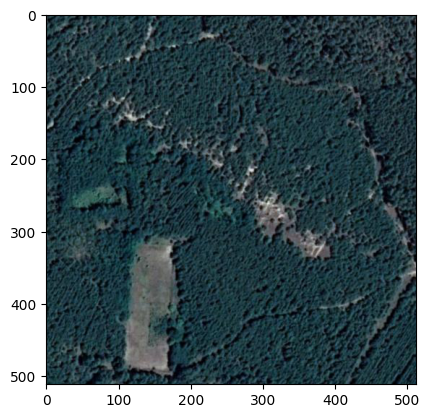

In [44]:
image, mask = get_example("/Users/dhruval/Desktop/Applicative/deforest/Satellite-Image-Segmentation-using-Deep-Learning-for-Deforestation-Detection/Dataset/extracted_dataset/tfrecords_v2_part_1.tfrec", 3)
plt.imshow(image)

In [45]:
image = image[np.newaxis, ...]
prediction = model.predict(image)
prediction_class1 = np.copy(prediction[..., 0]) # Forest
prediction_class2 = np.copy(prediction[..., 1]) # Deforest
prediction[..., 0] = prediction_class2 # RED - Deforest
prediction[..., 1] = prediction_class1 # GREEN - Forest

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


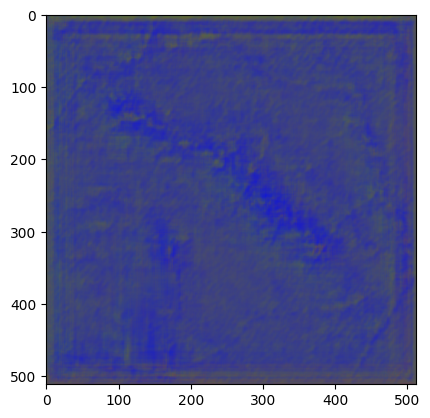

In [46]:
plt.imshow(prediction[0])